In [2]:
spark

NameError: name 'spark' is not defined

In [3]:
import io
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from pyspark.sql.functions import col, isnan, when, count, udf, to_date, year, month, hour, date_format, size, split
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

ModuleNotFoundError: No module named 'pyspark'

In [ ]:
all_data = "gs://my-bigdata-project-ra/cleaned/"
df = spark.read.parquet(all_data + "cleaned_yellow_tripdata_2022-*.parquet")
df.show(5)
print("Total records:", df.count())

In [5]:
df = df.withColumn('pickup_date', to_date(col("tpep_pickup_datetime"), 'yyyy-MM-dd'))
df = df.withColumn("pickup_hour", hour(col("tpep_pickup_datetime")))
df = df.withColumn("pickup_year", year(col("pickup_date")))
df = df.withColumn("pickup_month", month(col("pickup_date")))
df = df.withColumn("pickup_dayofweek", date_format(col("pickup_date"), "E"))  # 'Mon', 'Tue', etc.
df = df.withColumn("pickup_weekend", when(col("pickup_dayofweek").isin("Sat", "Sun"), 1.0).otherwise(0))
df = df.withColumn("DOLocationID", col("DOLocationID"))
df.select("tpep_pickup_datetime", "pickup_date", "pickup_hour", "pickup_year", "pickup_month",
          "pickup_dayofweek", "pickup_weekend", "PULocationID", "DOLocationID", 
          "passenger_count", "trip_distance", "fare_amount", "tip_amount", "total_amount", "airport_fee").show(10)
count_records = df.count()
print("Total records:", count_records)
df.select("passenger_count", "fare_amount", "tip_amount", "total_amount", "trip_distance", "airport_fee").summary("count", "min", "max", "mean").show()

+--------------------+-----------+-----------+-----------+------------+----------------+--------------+------------+------------+---------------+-------------+-----------+----------+------------+-----------+
|tpep_pickup_datetime|pickup_date|pickup_hour|pickup_year|pickup_month|pickup_dayofweek|pickup_weekend|PULocationID|DOLocationID|passenger_count|trip_distance|fare_amount|tip_amount|total_amount|airport_fee|
+--------------------+-----------+-----------+-----------+------------+----------------+--------------+------------+------------+---------------+-------------+-----------+----------+------------+-----------+
| 2022-10-01 00:03:41| 2022-10-01|          0|       2022|          10|             Sat|           1.0|         249|         107|            1.0|          1.7|        9.5|      2.65|       15.95|        0.0|
| 2022-10-01 00:14:30| 2022-10-01|          0|       2022|          10|             Sat|           1.0|         151|         238|            2.0|         0.72|        5

+-------+------------------+------------------+-----------------+------------------+-----------------+-------------------+
|summary|   passenger_count|       fare_amount|       tip_amount|      total_amount|    trip_distance|        airport_fee|
+-------+------------------+------------------+-----------------+------------------+-----------------+-------------------+
|  count|          38287795|          39656098|         39656098|          39656098|         39656098|           39656098|
|    min|               0.0|     -1.33391414E8|           -410.0|           -2567.8|              0.0|              -1.25|
|    max|               9.0|         401092.32|   1.3339136353E8|         401095.62|        389678.46|               1.25|
|   mean|1.4011492173942115|10.362821757456953|7.234908207559228|21.671268443330533|5.959398968097749|0.09405799330029899|
+-------+------------------+------------------+-----------------+------------------+-----------------+-------------------+



In [6]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.functions import col, when

dayofweek_indexer = StringIndexer(inputCol="pickup_dayofweek", outputCol="pickup_dayofweek_index")
location_indexer = StringIndexer(inputCols=["PULocationID", "DOLocationID"], 
                                 outputCols=["PULocationID_indexed", "DOLocationID_indexed"])

encoder = OneHotEncoder(inputCols=["pickup_dayofweek_index", "pickup_month", "PULocationID_indexed", "DOLocationID_indexed"],
                        outputCols=["pickup_dayofweek_encoded", "pickup_month_encoded", "PULocationID_encoded", "DOLocationID_encoded"])

assembler = VectorAssembler(
    inputCols=["pickup_month_encoded", "pickup_dayofweek_encoded", "PULocationID_encoded", "DOLocationID_encoded",
               "pickup_weekend", "passenger_count", "trip_distance", "total_amount", "airport_fee"],
    outputCol="features",
    handleInvalid="skip")  

pipeline = Pipeline(stages=[dayofweek_indexer, location_indexer, encoder, assembler])

transformed_df = pipeline.fit(df).transform(df)

transformed_df.select("PULocationID", "DOLocationID", "pickup_month", "pickup_dayofweek", "pickup_weekend", "passenger_count", 
                      "trip_distance", "total_amount", "airport_fee", "features").show(truncate=False)

+------------+------------+------------+----------------+--------------+---------------+-------------+------------+-----------+--------------------------------------------------------------------------+
|PULocationID|DOLocationID|pickup_month|pickup_dayofweek|pickup_weekend|passenger_count|trip_distance|total_amount|airport_fee|features                                                                  |
+------------+------------+------------+----------------+--------------+---------------+-------------+------------+-----------+--------------------------------------------------------------------------+
|138         |252         |2           |Tue             |0.0           |1.0            |5.4          |23.45       |1.25       |(545,[2,16,30,435,541,542,543,544],[1.0,1.0,1.0,1.0,1.0,5.4,23.45,1.25])  |
|138         |41          |2           |Tue             |0.0           |1.0            |6.4          |30.1        |1.25       |(545,[2,16,30,326,541,542,543,544],[1.0,1.0,1.0,1.0,1.0,6.4,3

In [7]:
transformed_df = pipeline.fit(df).transform(df)

transformed_df.select("PULocationID", "DOLocationID", "pickup_month", "pickup_dayofweek",
                      "pickup_weekend", "passenger_count", "trip_distance",
                      "total_amount", "airport_fee", "features").show(truncate=False)

trusted_folder = "gs://my-bigdata-project-ra/trusted/"

transformed_df.write.parquet(path=trusted_folder + "featured_data.parquet", mode="overwrite")


24/04/19 16:43:23 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+------------+------------+------------+----------------+--------------+---------------+-------------+------------+-----------+--------------------------------------------------------------------------+
|PULocationID|DOLocationID|pickup_month|pickup_dayofweek|pickup_weekend|passenger_count|trip_distance|total_amount|airport_fee|features                                                                  |
+------------+------------+------------+----------------+--------------+---------------+-------------+------------+-----------+--------------------------------------------------------------------------+
|138         |252         |2           |Tue             |0.0           |1.0            |5.4          |23.45       |1.25       |(545,[2,16,30,435,541,542,543,544],[1.0,1.0,1.0,1.0,1.0,5.4,23.45,1.25])  |
|138         |41          |2           |Tue             |0.0           |1.0            |6.4          |30.1        |1.25       |(545,[2,16,30,326,541,542,543,544],[1.0,1.0,1.0,1.0,1.0,6.4,3

In [8]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

df_sample = transformed_df.sample(False, 0.70)
print("sampled data:", df_sample.count())

(trainingData, testData) = df_sample.randomSplit([0.7, 0.3], seed=42)

linear_reg = LinearRegression(labelCol='tip_amount', featuresCol='features')

evaluator = RegressionEvaluator(labelCol='tip_amount', metricName='rmse')

paramGrid = ParamGridBuilder() \
    .addGrid(linear_reg.elasticNetParam, [0.0, 0.5, 1.0]) \
    .addGrid(linear_reg.regParam, [0.01, 0.1, 1.0]) \
    .build()

cv = CrossValidator(estimator=linear_reg, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=3)

all_models = cv.fit(trainingData)

print(f"Average metric {all_models.avgMetrics}")

bestModel = all_models.bestModel

test_results = bestModel.transform(testData)

test_results.select("PULocationID", "DOLocationID", "passenger_count", "trip_distance", "total_amount", "airport_fee", "tip_amount", "prediction").show(truncate=False)


rmse = evaluator.evaluate(test_results, {evaluator.metricName: 'rmse'})
r2_evaluator = RegressionEvaluator(labelCol='tip_amount', predictionCol='prediction', metricName='r2')
r2 = r2_evaluator.evaluate(test_results)

print(f"RMSE: {rmse}  R-squared:{r2}")

sampled data: 26800623


Average metric [7.454166460370673, 7.191154198234202, 5.698035977493475, 7.4734928626078405, 7.399060792350967, 6.07164361161134, 7.494597083971257, 7.532757800702062, 5.381806913175872]


+------------+------------+---------------+-------------+------------+-----------+----------+-----------------+
|PULocationID|DOLocationID|passenger_count|trip_distance|total_amount|airport_fee|tip_amount|prediction       |
+------------+------------+---------------+-------------+------------+-----------+----------+-----------------+
|163         |230         |1.0            |1.0          |10.23       |0.0        |0.93      |2.660752328642862|
|238         |41          |1.0            |1.6          |12.8        |0.0        |1.0       |2.660752328642862|
|144         |186         |2.0            |2.5          |16.55       |0.0        |2.75      |2.660752328642862|
|132         |48          |1.0            |18.0         |67.85       |1.25       |11.3      |3.345349827260867|
|79          |144         |2.0            |0.7          |11.15       |0.0        |1.85      |2.660752328642862|
|162         |107         |1.0            |1.6          |12.95       |0.0        |2.15      |2.660752328

RMSE: 3.1720395929572  R-squared:0.038618880610234774


In [9]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit

results_df = test_results.withColumn("RMSE", lit(rmse)).withColumn("R_squared", lit(r2))

save_results = "gs://my-bigdata-project-ra/trusted/results/"

results_df.write.format("parquet").mode("overwrite").save(save_results)

print(f"Results saved to {save_results}")

Results saved to gs://my-bigdata-project-ra/trusted/results/


In [10]:
model_folder = "gs://my-bigdata-project-ra/models/best_linear_regression_model"
bestModel.save(model_folder)
print(f"Model saved to {model_folder}")

Model saved to gs://my-bigdata-project-ra/models/best_linear_regression_model


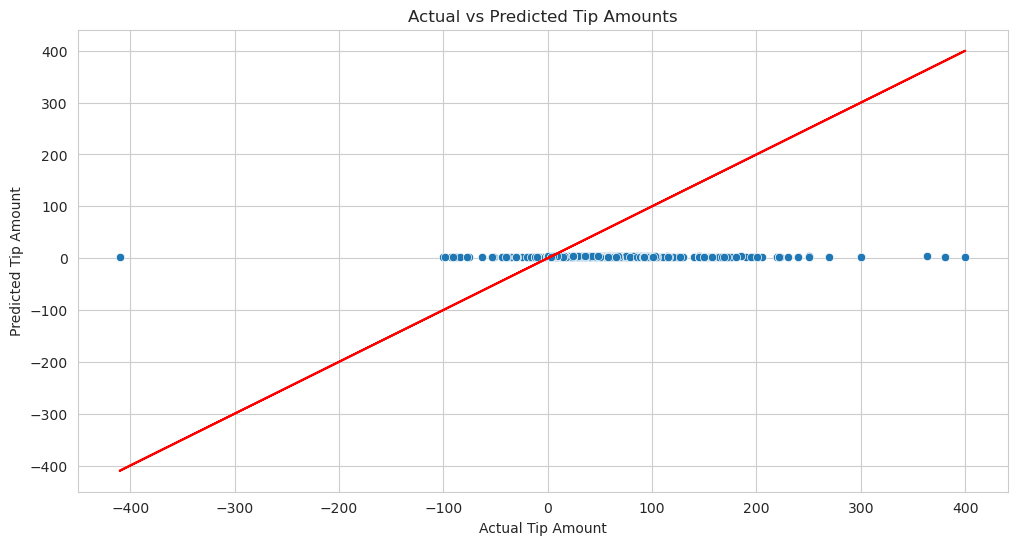

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

pdf_test_results = test_results.select('tip_amount', 'prediction').toPandas()

sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))
sns.scatterplot(x='tip_amount', y='prediction', data=pdf_test_results)
plt.plot(pdf_test_results['tip_amount'], pdf_test_results['tip_amount'], color='red')  
plt.title('Actual vs Predicted Tip Amounts')
plt.xlabel('Actual Tip Amount')
plt.ylabel('Predicted Tip Amount')
plt.show()


/opt/conda/miniconda3/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in true_divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


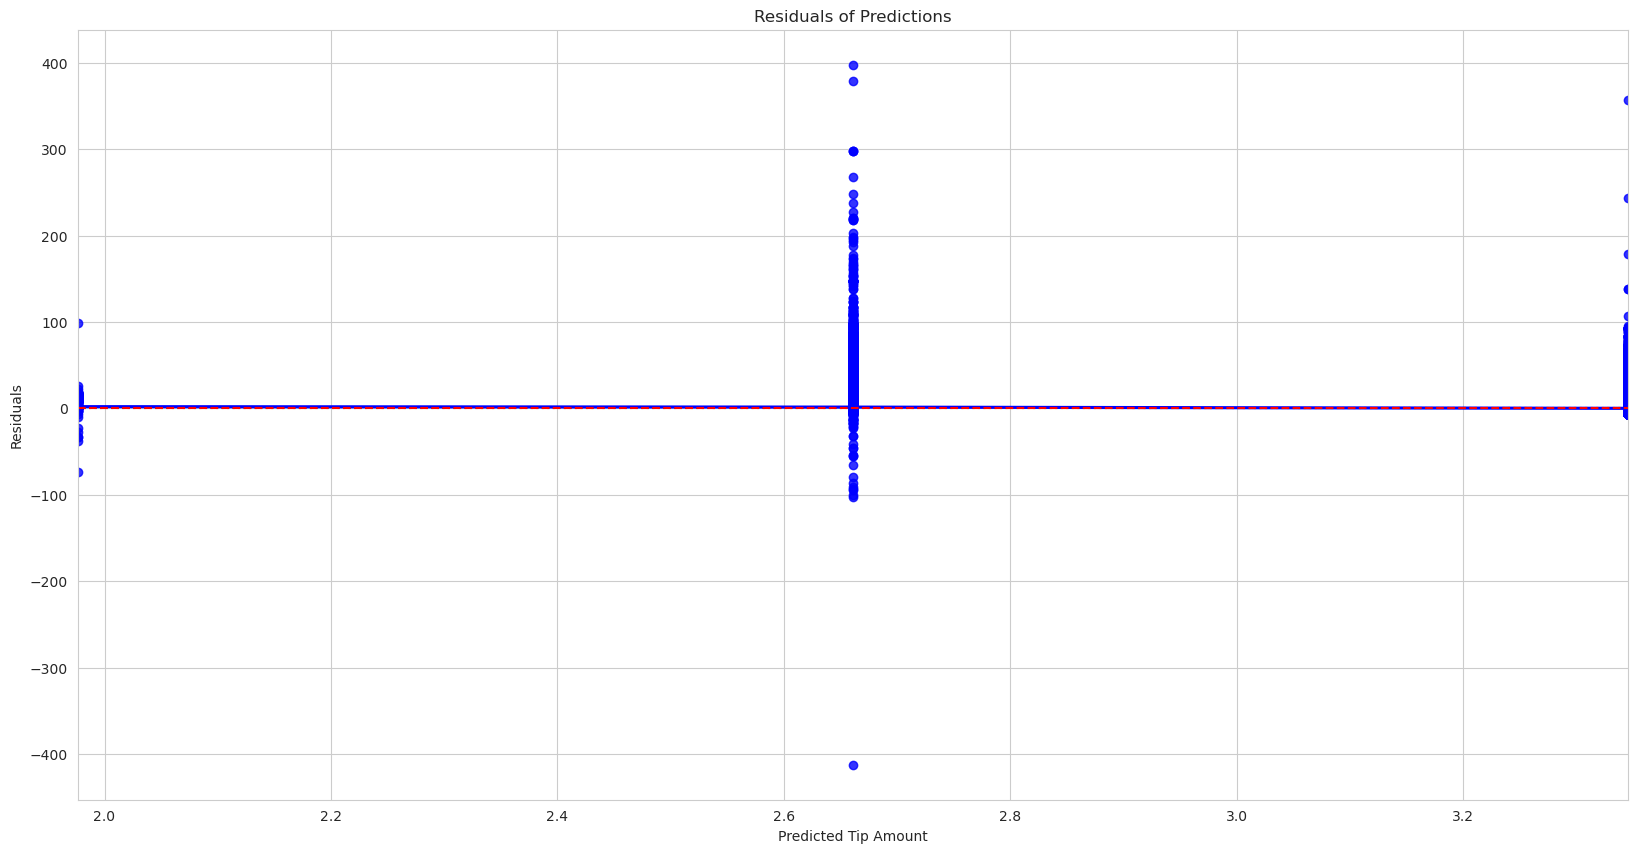

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

pdf_test_results['residuals'] = pdf_test_results['tip_amount'] - pdf_test_results['prediction']

plt.figure(figsize=(20, 10))
sns.residplot(x='prediction', y='residuals', data=pdf_test_results, color='blue', lowess=True)
plt.title('Residuals of Predictions')
plt.xlabel('Predicted Tip Amount')
plt.ylabel('Residuals')
plt.axhline(y=0, color='red', linestyle='--')
plt.show()